In [ ]:
!pip install pysindy

In [64]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pysindy as ps
from pysindy.optimizers import SR3
from pysindy.optimizers import FROLS
from pysindy.optimizers.sindy_pi import SINDyPI
from pysindy.optimizers import SSR

# Introdução

A principal ideia do  SINDy (Sparse Identification of Nonlinear Dynamics) é utilizar uma regressão esparsa para encontrar uma combinação linear de funções que melhor captura  o comportamento da dinâmica de um sistema físico.

Para esse fim, precisamos coletar dados nos tempos $t_1, t_2, \dots, t_n$ das medições do sistema e suas derivadas, representadas pelas seguintes matrizes.

$\begin{split}X = \begin{bmatrix}
    x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
    x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
    \vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
\end{bmatrix},
\qquad
\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
    \dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
    \vdots & \vdots & & \vdots \\
    \dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
\end{bmatrix}.\end{split}$

Após a coleta de dados, escolhemos uma matriz de funções $\Theta(X)$, chamada de biblioteca.

$\begin{split}\Theta(X) = \begin{bmatrix}
    \mid & \mid & & \mid \\
    \theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
    \mid & \mid & & \mid
\end{bmatrix}.\end{split}$

Por fim, queremos encontrar uma matriz esparsa de coeficientes $\Xi$ onde cada coluna nos dá os coeficientes da combinação linear  do conjunto de funções na biblioteca.
 $\begin{split}\Xi = \begin{bmatrix}
    \mid & \mid & & \mid \\
    \xi_1 & \xi_2 & \dots & \xi_n \\
    \mid & \mid & & \mid
\end{bmatrix}.\end{split}$

Sendo assim, temos o seguinte problema de aproximação
$$\dot X \approx \Theta(X)\Xi.$$

# Problema 1

Temos o seguinte problema

\begin{align*}
\dot{x}_1 &= -2x_1 + a_1x_2x_3 + a_2x_4x_5 \\
\dot{x}_2 &= -9x_2 + bx_1x_3 \\
\dot{x}_3 &= -5c_3 - cx_1x_2 + Re \\
\dot{x}_4 &= -5x_4 - dx_1x_5 \\
\dot{x}_5 &= -x_5 + ex_1x_2 \\
\end{align*},

onde $a_1 = 15 , a_2 = 1, b = 2.3 , c = 5 , Re = 4 , d = 0 ,  e = 3$. Para o treinamento do modelo serão utilizadas as condições iniciais $x_1(0) = 2, x_2(0) = 1, x_3(0) = 3, x_4(0) = 1, x_5(0) = 4$. Após o treino, o modelo irá simular a evolução do sistema a partir de diferentes condições.

In [3]:
def navier_stokes(t, z, a1, a2, b, c, Re, d, e):
    x1, x2, x3, x4, x5 = z
    return np.array([
        -2*x1 + a1*x2*x3 + a2*x4*x5,
        -9*x2 + b*x1*x3,
        -5*x3 - c*x1*x2 + Re,
        -5*x4 - d*x1*x5,
        -x5 - e*x1*x5
    ])

## Gerando dados  

In [49]:
t = np.linspace(0, 3, 5000)
x0_train = [2, 1, 3, 1, 4]
sol = solve_ivp(navier_stokes, [0, 3], x0_train, t_eval = t, args = (15, 1, 2.3, 5, 4, 0, 3))
x_train = sol.y.T
x_dot_train = ps.FiniteDifference()._differentiate(x_train, t)

In [6]:
dados = [(x, x_dot) for x, x_dot in zip(x_train, x_dot_train)]

## Solução usando Runge-Kutta

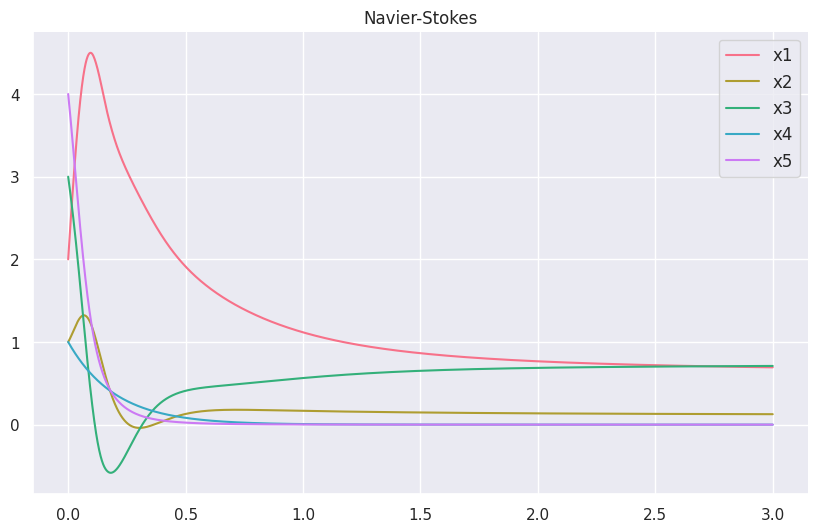

In [50]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('husl', n_colors=5)

for i in range(5):
    sns.lineplot(x=t, y=x_train[:, i], ax=ax, label=f'x{i + 1}', color=colors[i])

ax.set(title='Navier-Stokes')

ax.legend(loc='upper right', fontsize='medium')

sns.despine()

plt.show()

Como a dinâmica do sistema já é conhecida, será escolhida uma biblioteca de funções polinomiais de segundo grau.

In [65]:
feature_names = ["x1", "x2", "x3", "x4", "x5"]
differentiation_method = ps.FiniteDifference(order = 2)
feature_library = ps.PolynomialLibrary(degree = 2)
sr3 =  SR3(max_iter = 1000)
ssr = SSR()
stlsq = ps.STLSQ()
frols = FROLS()
model_sr = ps.SINDy(differentiation_method = differentiation_method, feature_names = feature_names, feature_library = feature_library, optimizer = sr3)
model_ssr = ps.SINDy(differentiation_method = differentiation_method, feature_names = feature_names, feature_library = feature_library, optimizer = ssr)
model_stlsq = ps.SINDy(differentiation_method = differentiation_method, feature_names = feature_names, feature_library = feature_library, optimizer = stlsq)
model_frols = ps.SINDy(differentiation_method = differentiation_method, feature_names = feature_names, feature_library = feature_library, optimizer = frols)

## Sparse Regularized Regression

Minimiza a seguinte função objetivo:

$$0.5\|y-Xw\|^2_2 + \lambda R(u)
+ (0.5 / \nu)\|w-u\|^2_2$$,
onde $R(u)$ é uma função  de regularização.

In [75]:
model_sr.fit(x_train, t=0.0006)
model_sr.print()

(x1)' = -142.536 1 + -14.645 x1 + -246.247 x2 + 287.779 x3 + 581.360 x4 + -726.051 x5 + 50.213 x1^2 + 19.269 x1 x2 + 18.605 x1 x3 + -789.286 x1 x4 + 332.560 x1 x5 + -101.084 x2^2 + 66.185 x2 x3 + -77.662 x2 x4 + -1136.021 x2 x5 + -118.725 x3^2 + -1063.996 x3 x4 + 346.505 x3 x5 + 684.480 x4^2 + 3757.664 x4 x5 + -662.424 x5^2
(x2)' = -28.457 1 + -7.607 x1 + -49.332 x2 + 58.113 x3 + 40.962 x4 + -2.868 x5 + 13.428 x1^2 + -1.797 x1 x2 + 6.688 x1 x3 + -163.564 x1 x4 + 60.946 x1 x5 + -31.374 x2^2 + 18.136 x2 x3 + 33.481 x2 x4 + -279.100 x2 x5 + -23.831 x3^2 + -184.077 x3 x4 + 66.910 x3 x5 + 5.330 x4^2 + 777.855 x4 x5 + -153.111 x5^2
(x3)' = 19.927 1 + -31.622 x1 + 91.208 x2 + -31.777 x3 + -668.334 x4 + 1233.066 x5 + 15.565 x1^2 + -43.253 x1 x2 + 1.936 x1 x3 + 84.931 x1 x4 + -68.520 x1 x5 + -68.508 x2^2 + 47.486 x2 x3 + 317.836 x2 x4 + -455.643 x2 x5 + 10.374 x3^2 + 440.294 x3 x4 + -51.967 x3 x5 + -1529.822 x4^2 + 363.169 x4 x5 + -195.578 x5^2
(x4)' = -5.001 x4
(x5)' = 1.430 1 + 11.568 x1 + -1

## Stepwise Sparse Regression

Minimiza $\|y - Xw\|^2_2 + \alpha \| w\|^2_2$  eliminando iterativamente os menores coeficientes.

In [76]:
model_ssr.fit(x_train, t=0.0006)
model_ssr.print()

(x1)' = 13.778 1 + -13.386 x1 + -63.436 x2 + -12.206 x3 + 355.933 x4 + -278.632 x5 + 21.807 x1 x2 + 21.820 x1 x3 + -56.932 x1 x4 + 60.894 x2^2 + -16.223 x2 x3 + -177.533 x2 x4 + 175.249 x2 x5 + -416.035 x3 x4 + 89.512 x3 x5 + 123.543 x4 x5
(x2)' = -4.521 1 + 7.250 x1 + -29.945 x2 + -0.270 x3 + 19.128 x4 + 27.725 x5 + -3.296 x1^2 + 8.489 x1 x2 + 3.719 x1 x3 + 24.029 x2^2 + -9.497 x2 x3 + -84.025 x2 x4 + -18.982 x2 x5 + 5.833 x3^2 + 80.739 x4 x5 + -21.351 x5^2
(x3)' = 23.119 1 + -4.658 x1 + -42.481 x3 + 106.861 x5 + -32.571 x1 x2 + 7.060 x1 x3 + -13.044 x1 x4 + 51.421 x2^2 + 12.033 x2 x3 + 366.783 x2 x4 + -125.904 x2 x5 + 15.404 x3^2 + -1.005 x3 x4 + 3.703 x3 x5 + -246.967 x4^2 + -10.616 x5^2
(x4)' = 0.002 1 + 0.007 x1 + -0.019 x2 + -0.013 x3 + -4.983 x4 + -0.052 x5 + -0.004 x1^2 + 0.002 x1 x2 + 0.002 x1 x3 + 0.015 x1 x4 + 0.032 x2^2 + -0.008 x2 x3 + 0.010 x2 x5 + 0.012 x3^2 + -0.007 x3 x5 + 0.009 x5^2
(x5)' = 1.766 1 + -1.165 x1 + -4.097 x3 + -37.437 x5 + 3.798 x1 x2 + 1.211 x1 x3 + 16.

## Sequentially Thresholded Least Squares

Busca minimizar $\|y - Xw\|^2_2 + \alpha \|w\|^2_2$ realizando mínimos quadrados a cada iteração e mascarando os pesos no vetor $w$ caso estejam abaixo de certo threshold.

In [77]:
model_stlsq.fit(x_train, t=0.0006)
model_stlsq.print()

(x1)' = -12.429 1 + 30.872 x1 + -171.162 x2 + -11.062 x3 + 401.202 x4 + -121.205 x5 + -19.089 x1^2 + 60.244 x1 x2 + 24.885 x1 x3 + -18.695 x1 x4 + 181.132 x2^2 + -63.166 x2 x3 + -558.224 x2 x4 + 10.925 x2 x5 + 29.547 x3^2 + -381.363 x3 x4 + 82.389 x3 x5 + -454.261 x4^2 + 890.391 x4 x5 + -160.457 x5^2
(x2)' = -3.770 1 + -3.008 x1 + -19.019 x2 + 5.754 x3 + -47.444 x4 + 181.286 x5 + 2.053 x1^2 + 4.844 x1 x2 + 6.410 x1 x3 + -6.937 x1 x4 + -2.956 x1 x5 + 0.652 x2^2 + -2.142 x2 x3 + -69.904 x2 x4 + -106.893 x2 x5 + -0.429 x3^2 + 11.833 x3 x5 + -325.468 x4^2 + 323.733 x4 x5 + -80.284 x5^2
(x3)' = 19.927 1 + -31.622 x1 + 91.208 x2 + -31.777 x3 + -668.334 x4 + 1233.066 x5 + 15.565 x1^2 + -43.253 x1 x2 + 1.936 x1 x3 + 84.931 x1 x4 + -68.520 x1 x5 + -68.508 x2^2 + 47.486 x2 x3 + 317.836 x2 x4 + -455.643 x2 x5 + 10.374 x3^2 + 440.294 x3 x4 + -51.967 x3 x5 + -1529.822 x4^2 + 363.169 x4 x5 + -195.578 x5^2
(x4)' = 0.266 1 + 0.721 x2 + -0.176 x1^2 + -0.437 x2^2 + -0.554 x3^2
(x5)' = -0.417 x5 + -0.120

## Forward Regression Orthogonal Least-Squares

Minimiza $\|y - Xw\|^2_2 + \alpha \|w\|^2_2$ selecionando iterativamente a função mais correlacionada da biblioteca.

In [78]:
model_frols.fit(x_train, t=0.0006)
model_frols.print()

(x1)' = -1.978 x1 + -0.316 x1 x3 + 2.244 x2^2 + 16.142 x2 x3 + -1.860 x2 x5 + 2.656 x3 x4
(x2)' = 0.142 x1 + -9.409 x2 + -0.052 x1^2 + 2.231 x1 x3 + 0.760 x2^2
(x3)' = -0.333 x1 + -23.022 x4 + 7.216 x5 + 1.146 x1^2 + -2.487 x1 x2 + -5.942 x2^2 + -41.624 x2 x4 + 26.115 x4 x5 + -5.163 x5^2
(x4)' = 0.001 1 + -4.990 x4 + -0.001 x3^2
(x5)' = 1.123 x2 + -6.193 x5 + -0.253 x1 x2 + -0.157 x1 x3 + -2.436 x1 x5 + -0.342 x2^2 + -0.393 x2 x3 + 2.941 x3 x4 + 9.300 x4^2


## Simulação

In [80]:
#sim_sr = model_sr.simulate(x0_train, t)
sim_ssr = model_ssr.simulate(x0_train, t)
sim_stlsq = model_stlsq.simulate(x0_train, t)
sim_frols = model_frols.simulate(x0_train, t)

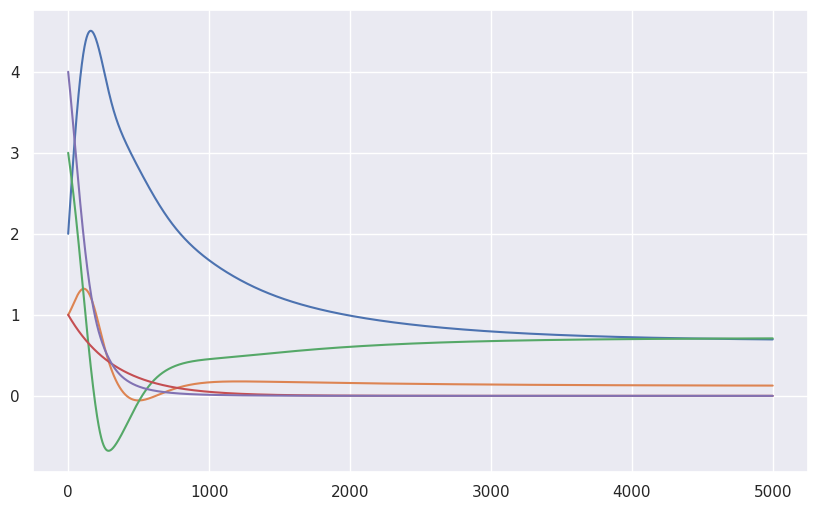

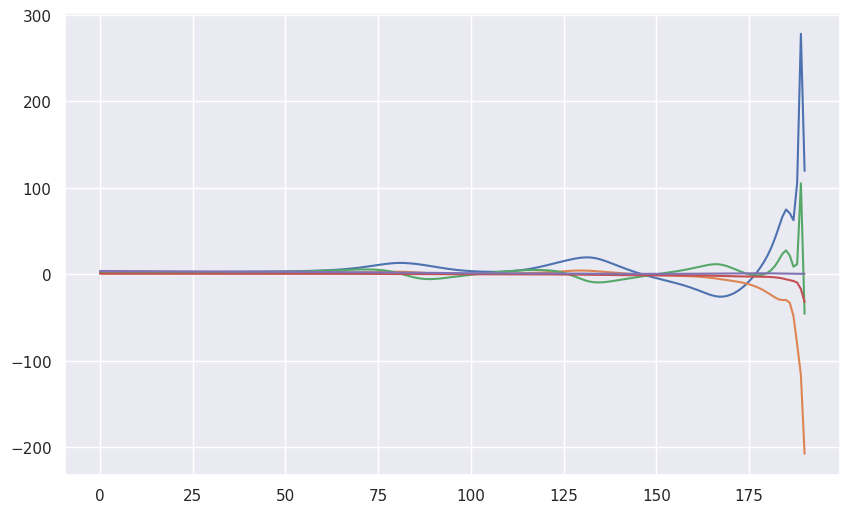

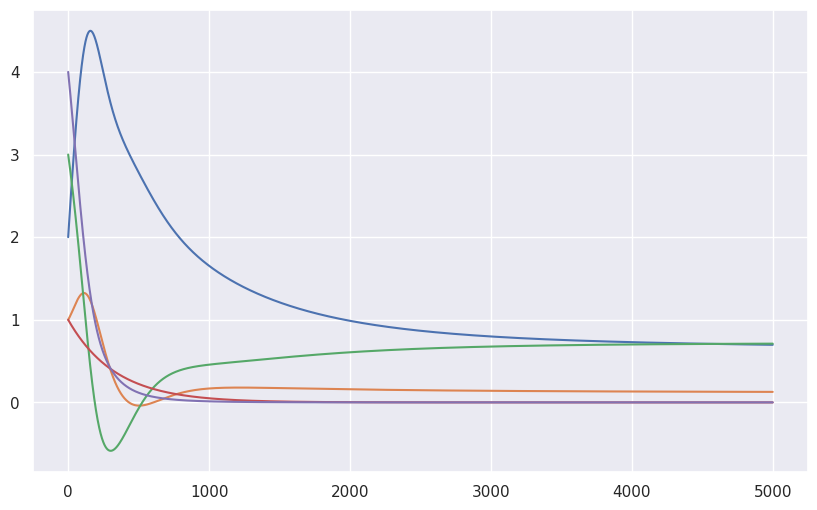

In [88]:

for i, array in enumerate([sim_ssr, sim_stlsq, sim_frols], start=0):
    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(array.shape[1]):
        ax.plot(array[:, j])
    plt.show()

# Problema 2

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class AutoencoderSINDy(nn.Module):
    def __init__(self, input_size,  latent_size) -> None:
        super().__init__()
        self.sindy_weights = nn.Linear(25, 5).to(torch.float64)
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 10).to(torch.float64),
            nn.ReLU(),
            nn.Linear(10,  5).to(torch.float64),
            nn.ReLU(),
            nn.Linear(5, 5).to(torch.float64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 5).to(torch.float64),
            nn.ReLU(),
            nn.Linear(5, input_size).to(torch.float64),
            nn.ReLU()
        )
    def forward(self, x) -> tuple:
        x.requires_grad_(True)
        z = self.encoder(x)
        z.requires_grad_(True)
        sindy_library = torch.cat([torch.sin(z), torch.cos(z), torch.pow(z, 1), torch.pow(z, 2), torch.pow(z, 3)], dim = 1)
        dz_sindy = self.sindy_weights(sindy_library)
        x_decoder = self.decoder(z)
        dz_dx = torch.autograd.grad(outputs=z, inputs=x, grad_outputs=torch.ones_like(z), create_graph=True)[0]
        dx_decoder_dx = torch.autograd.grad(outputs=x_decoder, inputs=z, grad_outputs=torch.ones_like(x_decoder), create_graph=True)[0]

        return z, dz_sindy, x_decoder, dz_dx, dx_decoder_dx, self.sindy_weights.weight


class Dados(Dataset):
    def __init__(self, data) -> None:
        self.data: list[tuple[list, list]] = data
    def __len__(self) -> int:
        return len(self.data);

    def __getitem__(self, idx: int) -> tuple[list, list]:
        return self.data[idx];

In [ ]:
train_dataset = Dados(dados)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

In [ ]:
def sindy_va_loss(data_set, z, dz_sindy, output, dz_dx, dx_decoder_dx, sindy_weights, l1, l2, l3) -> float:
    x, x_dot = data_set
    loss = nn.MSELoss()
    return loss(output,  x) + l2*torch.norm(sindy_weights, p = 1) + l3*loss(x_dot, dx_decoder_dx*dz_sindy) + l1*loss(x_dot*dz_dx, dz_sindy)

In [ ]:
def train(data, model, optimizer, sindy_va_loss):
    x, x_dot = data
    model.train()
    optimizer.zero_grad()
    z, dz_sindy, output, dz_dx, dx_decoder_dx, sindy_weights = model(x)
    loss = sindy_va_loss(data, z, dz_sindy, output,  dz_dx, dx_decoder_dx, sindy_weights, 0.5, 0.2, 0.3)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def validate_batch(data, model, sindy_va_loss):
    model.eval()
    z, dz_sindy, output, grad_encoder, grad_decoder = model(x)
    loss = sindy_va_loss(data, z, dz_sindy, output, 0.5, 0.2, 0.3)
    return loss


In [ ]:
model = AutoencoderSINDy(5, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 150
for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, data in enumerate(train_loader):
        loss = train(data, model, optimizer, sindy_va_loss)u
        pos = epoch + (1+batch_idx)/N
    print(f"epoch: {epoch} | loss: {loss}")

epoch: 0 | loss: 0.42334489529403657
epoch: 1 | loss: 0.5764073508233248
epoch: 2 | loss: 1.2535374768779495
epoch: 3 | loss: 2.6233611250234703
epoch: 4 | loss: 0.28881411656849326
epoch: 5 | loss: 1.3608457785828771
epoch: 6 | loss: 0.2888241738172985
epoch: 7 | loss: 0.04272168378461983
epoch: 8 | loss: 0.26506954284401324
epoch: 9 | loss: 0.486571699562011
epoch: 10 | loss: 1.9710196912483586
epoch: 11 | loss: 0.18663549608558802
epoch: 12 | loss: 1.3258829003071002
epoch: 13 | loss: 0.7415884059762052
epoch: 14 | loss: 0.6772679533683428
epoch: 15 | loss: 0.0573563657347473
epoch: 16 | loss: 1.401236260522489
epoch: 17 | loss: 3.2585623640179087
epoch: 18 | loss: 0.23067133617429023
epoch: 19 | loss: 0.4767141900783706
epoch: 20 | loss: 0.029610550050306196
epoch: 21 | loss: 0.3696979329589807
epoch: 22 | loss: 0.4936251768147877
epoch: 23 | loss: 0.11052318390609717
epoch: 24 | loss: 0.3384873609666932
epoch: 25 | loss: 1.6767435513346995
epoch: 26 | loss: 0.23940322378234596
epo